C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14512\3281520377.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rush_distance_summary = game_data_rushing.groupby('rush_distance_category').agg({
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14512\3281520377.py:99: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_data_rushing['x'] = game_data_rushing['run_location'].replace({'left': -1, 'middle': 0, 'right': 1})
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14512\3281520377.py:166: UserWarning: Tight layout not applied. tight_layout cannot

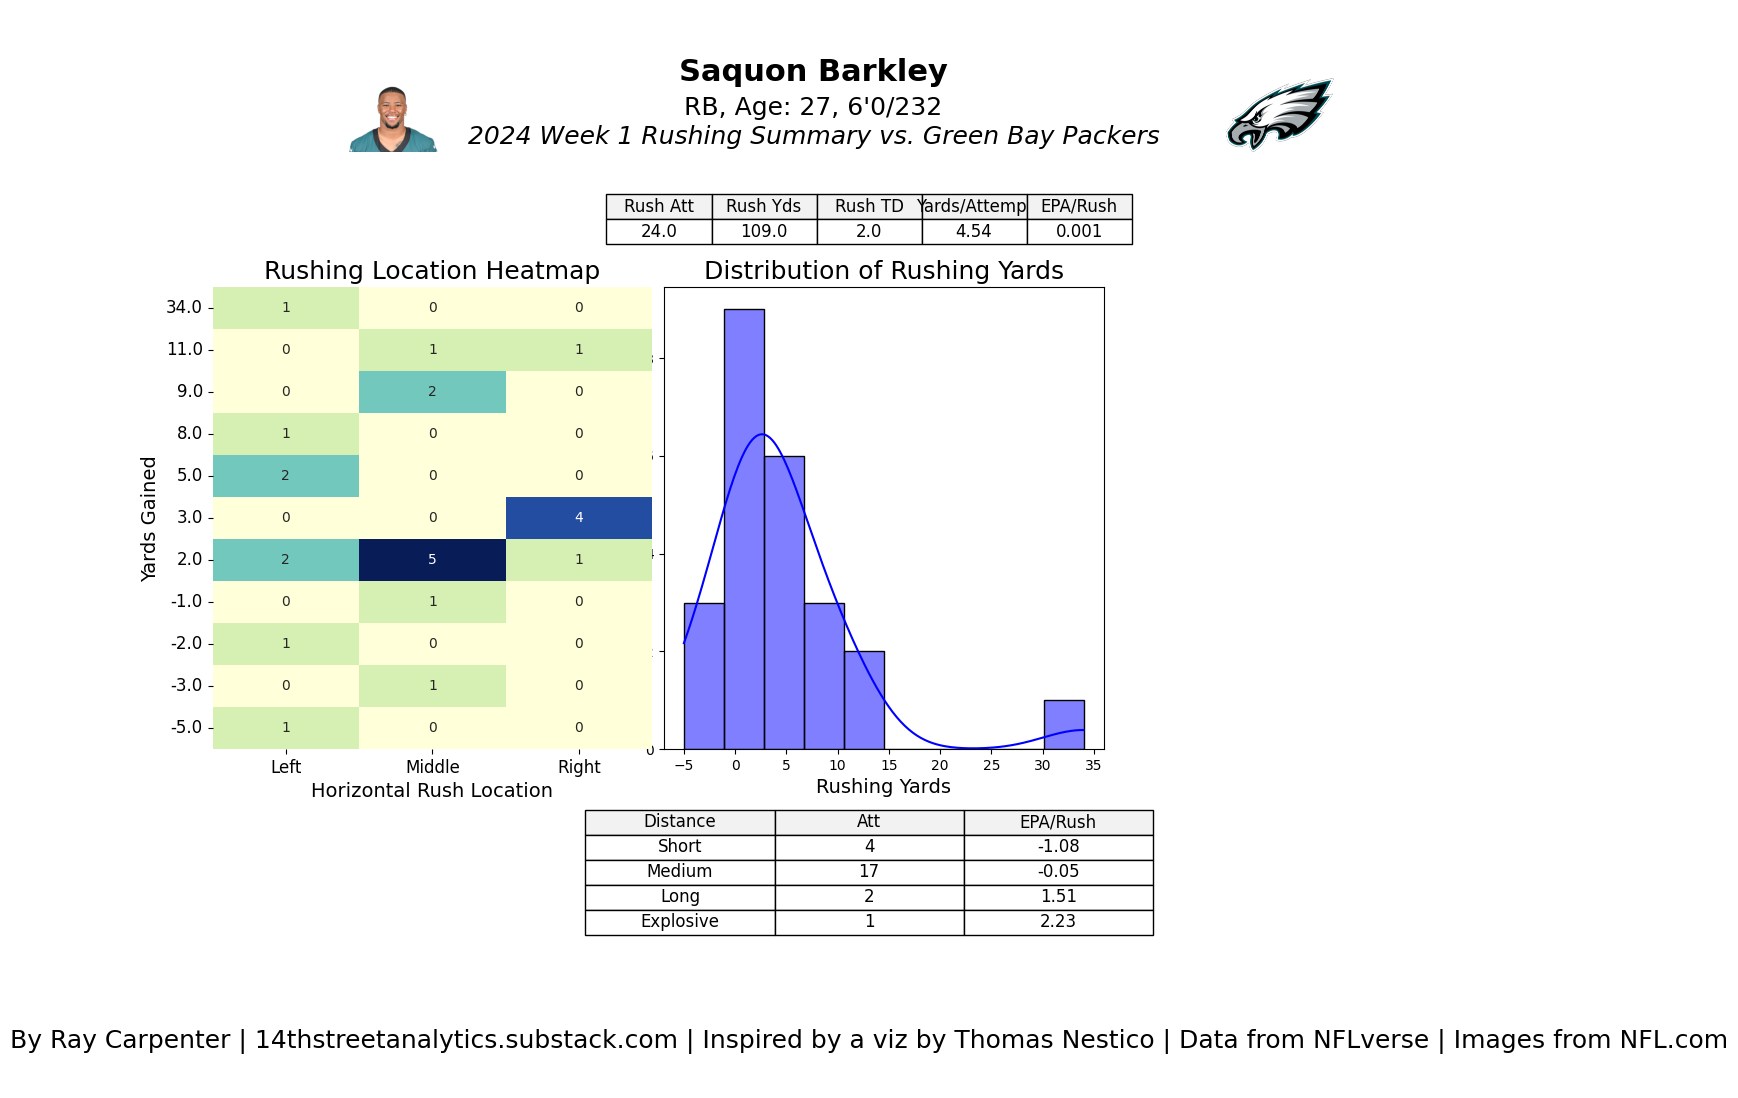

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from PIL import Image

# Define the year and load the data
YEAR = 2024
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Function to get an image from ESPN based on player_id
def get_espn_headshot(player_id: str):
    url = f'https://a.espncdn.com/combiner/i?img=/i/headshots/nfl/players/full/{player_id}.png'
    response = requests.get(url)
    
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        print(f"Could not retrieve headshot for player {player_id}")
        return None

def player_headshot(player_id: str, ax: plt.Axes):
    headshot = get_espn_headshot(player_id)
    
    if headshot:
        ax.imshow(headshot)
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No Image', ha='center', va='center', fontsize=12)
        ax.axis('off')

# Manually set player ID for Saquon Barkley
player_id = '3929630'
headshot = get_espn_headshot(player_id)

# Manual filters for team (Giants) and game
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]

# Filter rushing plays for Saquon Barkley
rushing_plays = filtered_df[filtered_df['rusher_player_name'] == 'S.Barkley']

# Filter game data by game ID
game_data_rushing = rushing_plays[rushing_plays['game_id'] == '2024_01_GB_PHI']

# Calculate cumulative rushing statistics
total_rushing_epa = game_data_rushing['epa'].sum()
rush_attempts = game_data_rushing['rush_attempt'].sum()
rush_yards = game_data_rushing['rushing_yards'].sum()
rush_touchdowns = game_data_rushing['rush_touchdown'].sum()

if rush_attempts == 0:
    rush_yards = 0
    rush_touchdowns = 0

yards_per_attempt = round(rush_yards / rush_attempts, 2) if rush_attempts > 0 else 0
epa_per_rush = round(total_rushing_epa / rush_attempts, 3) if rush_attempts > 0 else 0

summary_table = {
    'Rush Att': [int(rush_attempts)],        
    'Rush Yds': [int(rush_yards)],           
    'Rush TD': [int(rush_touchdowns)],       
    'Yards/Attempt': [yards_per_attempt],
    'EPA/Rush': [epa_per_rush]
}

summary_df = pd.DataFrame.from_dict(summary_table)

# Create bins for rush distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Short', 'Medium', 'Long', 'Explosive']
game_data_rushing['rush_distance_category'] = pd.cut(game_data_rushing['rushing_yards'], bins=bins, labels=labels)

rush_distance_summary = game_data_rushing.groupby('rush_distance_category').agg({
    'rush_attempt': 'sum',
    'epa': 'sum'
}).reset_index()

rush_distance_summary['EPA/Rush'] = (rush_distance_summary['epa'] / rush_distance_summary['rush_attempt']).round(2)

# Convert categorical column to string type
rush_distance_summary['rush_distance_category'] = rush_distance_summary['rush_distance_category'].astype(str)

# Now fill missing values
rush_distance_summary.fillna(0, inplace=True)

rush_distance_summary = rush_distance_summary[['rush_distance_category', 'rush_attempt', 'EPA/Rush']]
rush_distance_summary.columns = ['Distance', 'Att', 'EPA/Rush']
rush_distance_summary['Att'] = rush_distance_summary['Att'].astype(int)

# Map run location to numerical values for heatmap
game_data_rushing['x'] = game_data_rushing['run_location'].replace({'left': -1, 'middle': 0, 'right': 1})
game_data_rushing['y'] = game_data_rushing['rushing_yards']

# Load the Giants logo
logo_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/philadelphia-eagles-logo.png'  # Manually find logo path
logo = Image.open(logo_path)

def rb_dashboard(game_data_rushing: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, rush_distance_summary: pd.DataFrame, save_path: str = None):
    fig = plt.figure(figsize=(18, 14))  
    gs = gridspec.GridSpec(6, 20, height_ratios=[2, 4, 4, 25, 10, 5], width_ratios=[1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1])

    ax_headshot = fig.add_subplot(gs[1, 2:4])
    ax_bio = fig.add_subplot(gs[1, 5:13])
    ax_logo = fig.add_subplot(gs[1, 14:16])
    ax_summary_table = fig.add_subplot(gs[2, 1:19])
    ax_yards_dist = fig.add_subplot(gs[3, 7:13])
    ax_rush_distance = fig.add_subplot(gs[4, 1:19])
    ax_heatmap = fig.add_subplot(gs[3, 1:7])

    ax_footer = fig.add_subplot(gs[-1, 1:19])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    ax_footer.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    player_headshot(player_id, ax_headshot)
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    ax_bio.text(0.5, 0.95, 'Saquon Barkley', fontsize=22, ha='center', fontweight='bold')
    ax_bio.text(0.5, 0.50, 'RB, Age: 27, 6\'0/232', fontsize=18, ha='center')
    ax_bio.text(0.5, 0.1, '2024 Week 1 Rushing Summary vs. Green Bay Packers', fontsize=18, ha='center', fontstyle='italic')
    ax_bio.axis('off')

    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center', colColours=['#f2f2f2'] * len(summary_df.columns), colWidths=[0.1] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.8, 1.5)

    sns.histplot(game_data_rushing['rushing_yards'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Rushing Yards', fontdict={'size': 14})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 14})
    ax_yards_dist.set_title('Distribution of Rushing Yards', fontdict={'size': 18})

    ax_rush_distance.axis('off')
    rush_distance_table = ax_rush_distance.table(cellText=rush_distance_summary.values, colLabels=rush_distance_summary.columns, cellLoc='center', loc='center', colColours=['#f2f2f2'] * len(rush_distance_summary.columns), colWidths=[0.18] * len(rush_distance_summary.columns))
    rush_distance_table.auto_set_font_size(False)
    rush_distance_table.set_fontsize(12)
    rush_distance_table.scale(.8, 1.5)

    # Create a heatmap for rushing location
    heatmap_data = game_data_rushing.pivot_table(index='y', columns='x', aggfunc='size', fill_value=0)
    sns.heatmap(heatmap_data, cmap='YlGnBu', ax=ax_heatmap, annot=True, cbar=False)
    ax_heatmap.set_title('Rushing Location Heatmap', fontsize=18)
    ax_heatmap.set_xlabel('Horizontal Rush Location', fontsize=14)
    ax_heatmap.set_ylabel('Yards Gained', fontsize=14)
    ax_heatmap.set_xticklabels(['Left', 'Middle', 'Right'], fontsize=12)
    ax_heatmap.set_yticklabels(heatmap_data.index, fontsize=12)

    # Flip the Y-axis
    ax_heatmap.invert_yaxis()
    ax_heatmap.tick_params(axis='y', labelrotation=0)
    ax_footer.text(0.5, 0.5, 'By Ray Carpenter | 14thstreetanalytics.substack.com | Inspired by a viz by Thomas Nestico | Data from NFLverse | Images from NFL.com', ha='center', va='center', fontsize=18)

    plt.tight_layout(pad=1.5)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

save_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/rb_dashboard.png'

rb_dashboard(game_data_rushing, headshot, logo, summary_df, rush_distance_summary, save_path=save_path)
